In [ ]:
import os
from pathlib import Path

import numpy as np
import scipy as sp
import scipy.spatial

from matplotlib import pyplot as plt
from sklearn.manifold import MDS
from sklearn import manifold
from sklearn.decomposition import PCA

import ot
import shutil
from tqdm import tqdm

import ipynbname
import torch
from torch.autograd.functional import jacobian

## IMPORT USER DEFINED LIBRARIES ##################################################################
import utils


c:\Users\cocar\Documents\Repositories\GW_BCM\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Utils

In [2]:
import secrets

def simplex_grid(N=20):
    """Generate points on a 2D simplex grid (triangle) with N divisions per edge."""    
    N = 20
    pts = []
    for l in range(N + 1):
        for j in range(N + 1 - l):
            k = N - l - j
            pts.append((l / N, j / N, k / N))
    pts=np.array(pts)
    return pts

def random_rbf_deformation(pts,
                           num_ctrl=20,
                           sigma=0.3,
                           max_disp=0.3,
                           seed=None):
    """
    pts: (N, 2) array in some domain, e.g. [0,1]^2
    num_ctrl: number of random control points
    sigma: RBF width (in units of the domain)
    max_disp: max magnitude of control displacements (same units as coords)
    """
    if seed is None:
        seed = secrets.randbits(256)
    rng = np.random.default_rng(seed)

    # 1) Random control points within bounding box of pts
    mins = pts.min(axis=0)
    maxs = pts.max(axis=0)
    ctrl_pts = rng.uniform(mins, maxs, size=(num_ctrl, 2))

    # 2) Random displacements assigned to control points
    ctrl_disp = rng.uniform(-max_disp, max_disp, size=(num_ctrl, 2))

    # 3) Compute RBF weights for each data point
    #    shape: (N, num_ctrl)
    diff = pts[:, None, :] - ctrl_pts[None, :, :]      # (N, K, 2)
    sqdist = np.sum(diff**2, axis=-1)                  # (N, K)
    weights = np.exp(-sqdist / (2.0 * sigma**2))       # (N, K)

    # Normalize weights so they don't blow up
    weights_sum = np.sum(weights, axis=1, keepdims=True) + 1e-12
    weights = weights / weights_sum

    # 4) Interpolated displacement field at pts
    disp = weights @ ctrl_disp                          # (N, 2)

    # 5) Deformed points
    pts_deformed = pts + disp
    return pts_deformed, disp, ctrl_pts, ctrl_disp, seed


def plot_point_cloud(pts, title='Point Cloud'):
    """Plot 2D point cloud. pts is (N, 2) array."""
    plt.figure(figsize=(4,4))
    plt.scatter(pts[:,0], pts[:,1], s=10, c='k')
    plt.xlim(-0.1,1.1)
    plt.ylim(-0.1,1.1)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(title)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid()
    plt.show() 

def compute_distance_matrix(pts):
    """Compute pairwise Euclidean distance matrix for pts."""
    diff = pts[:, None, :] - pts[None, :, :]  # (N, N, 2)
    dist_matrix = np.sqrt(np.sum(diff**2, axis=-1))  # (N, N)
    return dist_matrix  


# Generate

Number of points in simplex grid with N=20: 231


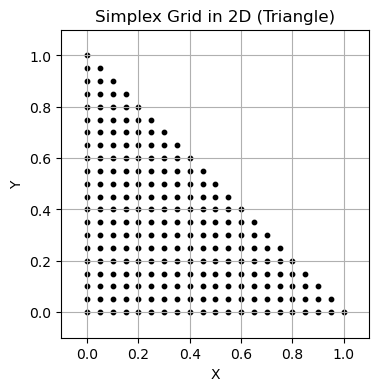

In [3]:
# ----------------------------------------------
# Generate simplex grid --> triangle (3 templates)
# ---------------------------------------------- 
N = 20
pts = simplex_grid(N) 
print('Number of points in simplex grid with N={}: {}'.format(N, pts.shape[0]))

plot_point_cloud(pts[:, :2], title='Simplex Grid in 2D (Triangle)')

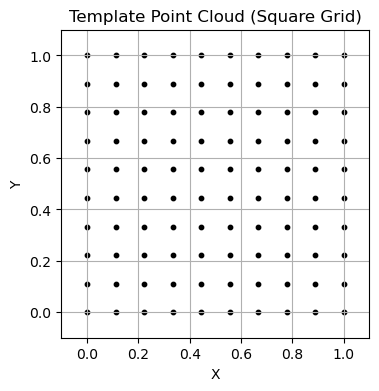

In [4]:
# ----------------------------------------------
# Generate a template cloud point in 2D that is a uniform grid in a square
# ----------------------------------------------
n_pts_per_side = 10
x = np.linspace(0, 1, n_pts_per_side)
y = np.linspace(0, 1, n_pts_per_side)
X, Y = np.meshgrid(x, y)
template_pts = np.vstack([X.ravel(), Y.ravel()]).T  # shape (n_pts_per_side**2, 2)          

plot_point_cloud(template_pts, title='Template Point Cloud (Square Grid)')
 

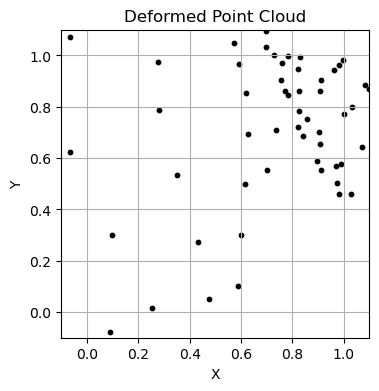

In [5]:
# -----------------------------------------------
# Example: Generate a random deformation of the template cloud
# -----------------------------------------------
deformed_pts, disp, ctrl_pts, ctrl_disp, seed = random_rbf_deformation(
    template_pts,
    num_ctrl=15,
    sigma=0.2,
    max_disp=1,
)

plot_point_cloud(deformed_pts, title='Deformed Point Cloud')


In [ ]:
# ----------------------------------------------
# Load (target)template and the first three deformed point clouds 
# ----------------------------------------------
output_dir = Path('./20-Exp-generated_data')

# Load template distance matrix to use as target
template_data = np.load(output_dir / 'template_point_cloud.npz')     
template_dist_matrix = template_data['distance_matrix']
target_dist_matrix = template_dist_matrix

# Load first three deformed point clouds   
assert len(os.listdir(output_dir)) >= 4, "Need at least 3 deformed point clouds saved."     
deformed_dist_matrices = []
deformed_measures = []
for idx in range(1, 4):
    deformed_data = np.load(output_dir / f'deformed_point_cloud_{idx}.npz')
    deformed_pts = deformed_data['points']
    deformed_dist_matrix = deformed_data['distance_matrix']
    deformed_dist_matrices.append(deformed_dist_matrix)
    deformed_measures.append(ot.unif(deformed_dist_matrix.shape[0]))

# ----------------------------------------------
# Load distance between barycenters and target data
# ----------------------------------------------
bary_dist_data = np.load(output_dir / 'Bary_distances_to_target.npz')
simplex_grid_points = bary_dist_data['simplex_grid_points']
simplex_gromov_wasserstein_distances_to_target = bary_dist_data['simplex_gromov_wasserstein_distances_to_target']



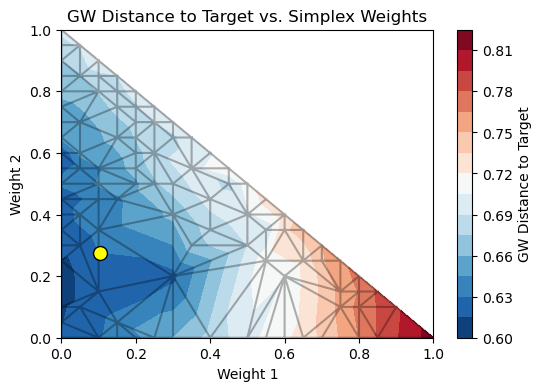

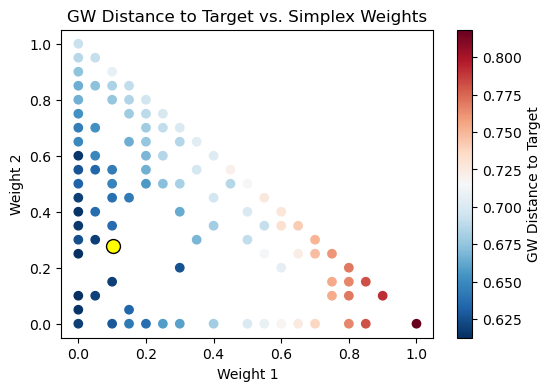

In [ ]:
import matplotlib.tri as tri

# Compute analysis of target 
_, lambdas = utils.get_lambdas_constraints(deformed_dist_matrices,deformed_measures,target_dist_matrix, ot.unif(target_dist_matrix.shape[0]))

# Clean up NaN values for plotting
z = simplex_gromov_wasserstein_distances_to_target
mask = np.isnan(z)
z_masked = z[~mask]
x_grid_points = simplex_grid_points[~mask,0]
y_grid_points = simplex_grid_points[~mask,1]

# Plot GW distances to target vs. simplex weights
plt.figure(figsize=(6,4))
plt.tricontourf(x_grid_points, y_grid_points, z_masked, levels=14, cmap="RdBu_r")
plt.colorbar(label='GW Distance to Target')
plt.xlabel('Weight 1')
plt.ylabel('Weight 2')
plt.title('GW Distance to Target vs. Simplex Weights')
# Add triangulation grid
triang = tri.Triangulation(x_grid_points, y_grid_points)
plt.triplot(triang, color='k', alpha=0.3)
plt.scatter(lambdas[0], lambdas[1], color='yellow', s=100, edgecolor='k', label='Computed Weights')
plt.show()

# Scatter plot of GW distances to target vs. simplex weights
plt.figure(figsize=(6,4))
plt.scatter(x_grid_points, y_grid_points, c=z_masked, cmap='RdBu_r')
plt.colorbar(label='GW Distance to Target')
plt.xlabel('Weight 1')
plt.ylabel('Weight 2')
plt.title('GW Distance to Target vs. Simplex Weights')
plt.scatter(lambdas[0], lambdas[1], color='yellow', s=100, edgecolor='k', label='Computed Weights')
plt.show()


In [ ]:
# ---------------------------------------------------
# Convert data to torch
# ---------------------------------------------------
Cs_torch = [torch.from_numpy(C).float().to(device) for C in Cs_except_i]
ps_torch = [torch.from_numpy(p).float().to(device) for p in ps_except_i]
C_target = torch.from_numpy(C_target_np).float().to(device) 
p_target = torch.from_numpy(p_target_np).float().to(device)



# lambda as a torch parameter (on simplex or not, up to you)
lambda_init = torch.ones(len(Cs_torch), device=device) / len(Cs_torch)
lambda_vec = lambda_init.clone().requires_grad_(True)